Members Name :


1.   Tiara Intana Sari (201810370311235)
2.   Zalfa Natania Ardilla (201810370311241)




# **Abusive Comment Identification on Indonesian Twitter using LSTM-RNN**

## **Mount Google Drive and Import Library**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import json
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from nltk.stem.wordnet import WordNetLemmatizer
import re, string
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ReduceLROnPlateau 


import warnings
warnings.filterwarnings("ignore")

In [ ]:
%cd /content/gdrive/My Drive/NLP/gemastik
!ls -a

/content/gdrive/My Drive/NLP/gemastik
'(1)revisi - Proposal Gemastik (Abusive Comment Detection).docx'
 abusive.csv
 abusive.png
 citation.bib
'confusion matriks'
'content word.png'
 data.csv
'Length Distribution'
 model_best.h5
 model_plot4a.png
 model_plot.png
 new_kamusalay.csv
 non-abusive.png
'(revisi) Progress 2 PD - 201810370311235 dan 201810370311241.pdf'
 stopwords.txt
 Text_Preprocessing2.csv
 Text_Preprocessing.csv
'tweet abusive Length Distribution'
'Tweet Non-Abusive Length Distribution'


## **Load Data**

**About Dataset**
***************************************************************************
[Indonesian Abusive and Hate Speech Twitter Text](https://https://www.kaggle.com/ilhamfp31/indonesian-abusive-and-hate-speech-twitter-text)



In [ ]:
df = pd.read_csv('data.csv', encoding='latin-1')
df.head()

,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,- disaat semua cowok berusaha melacak perhatia...,1,1,1,0,0,0,0,0,1,1,0,0
1,RT USER: USER siapa yang telat ngasih tau elu?...,0,1,0,0,0,0,0,0,0,0,0,0
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0,0,0,0,0,0,0,0,0,0,0,0
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0,0,0,0,0,0,0,0,0,0,0,0
4,USER USER Kaum cebong kapir udah keliatan dong...,1,1,0,1,1,0,0,0,0,0,1,0


## **Get Information About Dataset**

In [ ]:
df.shape

(13169, 13)

In [ ]:
del df['HS']
del df['HS_Individual']
del df['HS_Group']
del df['HS_Religion']
del df['HS_Race']
del df['HS_Physical']
del df['HS_Gender']
del df['HS_Other']
del df['HS_Weak']
del df['HS_Moderate']
del df['HS_Strong']

In [ ]:
df[df.Abusive == 1].head(5)

,Tweet,Abusive
0,- disaat semua cowok berusaha melacak perhatia...,1
1,RT USER: USER siapa yang telat ngasih tau elu?...,1
4,USER USER Kaum cebong kapir udah keliatan dong...,1
5,USER Ya bani taplak dkk \xf0\x9f\x98\x84\xf0\x...,1
7,Gue baru aja kelar re-watch Aldnoah Zero!!! pa...,1


In [ ]:
df[df.Abusive == 0].head(5)

,Tweet,Abusive
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0
6,deklarasi pilkada 2018 aman dan anti hoax warg...,0
8,Nah admin belanja satu lagi port terbaik nak m...,0
12,Kalo belajar ekonomi mestinya jago memprivatis...,0


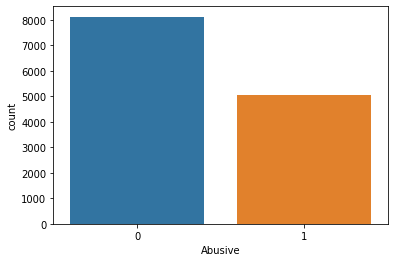

In [ ]:
sns.countplot(df.Abusive)

In [ ]:
data_1f = df[df.Abusive == 1]
original_data = df.copy()
df = pd.concat([df] + ([data_1f] * 1), axis=0)

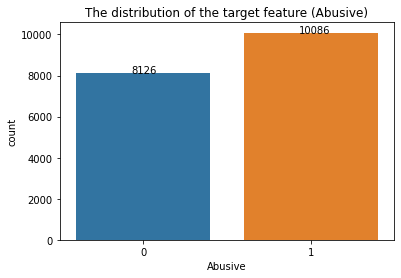

In [ ]:
plt.figure()
ax = sns.countplot(df.Abusive)
plt.title('The distribution of the target feature (Abusive)')
for p in ax.patches:
    ax.annotate(p.get_height(), (p.get_x()+0.33, p.get_height()))
plt.show()

In [ ]:
shuffled_df = df.sample(frac=1,random_state=4)
sentiment_df = shuffled_df.loc[shuffled_df['Abusive'] == 1].sample(n=8126,random_state=42)
non_sentiment_df = shuffled_df.loc[shuffled_df['Abusive'] == 0]

In [ ]:
df = pd.concat([sentiment_df, non_sentiment_df])

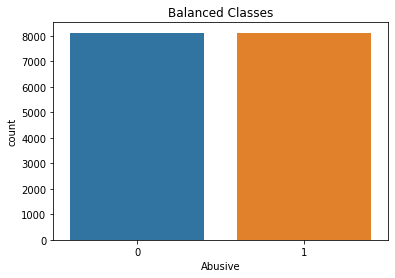

In [ ]:
plt.figure()
sns.countplot('Abusive', data=df)
plt.title('Balanced Classes')
plt.show()

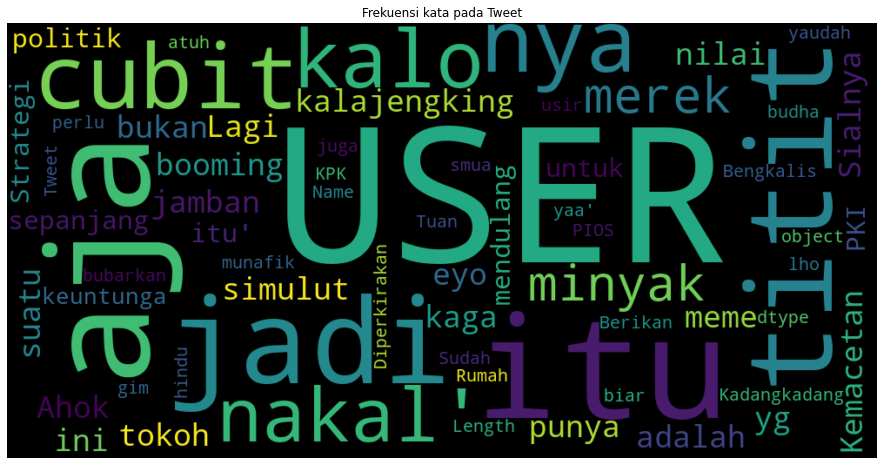

In [ ]:
plt.figure(figsize=(20,8))
wordcloud = WordCloud(background_color='black',
                    stopwords = STOPWORDS,
                    max_words = 100,
                    random_state = 101, 
                    width=1000, 
                    height=500)
wordcloud.generate(str(df['Tweet']))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Frekuensi kata pada Tweet")
plt.savefig("content word.png", format="png")
plt.show()

## **Data Cleaning & Pre-processing**

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
df['Tweet'] = df['Tweet'].str.lower()


print('Case Folding Result : \n')
print(df['Tweet'].head(5))

Case Folding Result : 

2776                  user cubit aja titit nya kalo nakal'
6456     user user itu minyak merek kalajengking, bukan...
839      user ahok simulut jamban, tokoh yg punya nilai...
12988    lagi booming meme ini. kemacetan adalah suatu ...
13099           user sialnya titit eyo kaga sepanjang itu'
Name: Tweet, dtype: object


In [ ]:
import string 
import re #regex library
from nltk.tokenize import word_tokenize 
from nltk.probability import FreqDist

# ------ Tokenizing ---------

def remove_tweet_special(text):
    # remove tab, new line, ans back slice
    text = text.replace('\\t'," ").replace('\\n'," ").replace('\\u'," ").replace('\\',"")
    # remove non ASCII (emoticon, chinese word, .etc)
    text = text.encode('ascii', 'replace').decode('ascii')
    # remove mention, link, hashtag
    text = ' '.join(re.sub("([@#][A-Za-z0-9]+)|(\w+:\/\/\S+)"," ", text).split())
    # remove incomplete URL
    return text.replace("http://", " ").replace("https://", " ")
                
df['Tweet'] = df['Tweet'].apply(remove_tweet_special)

#remove number
def remove_number(text):
    return  re.sub(r"\d+", "", text)

df['Tweet'] = df['Tweet'].apply(remove_number)

#remove punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans("","",string.punctuation))

df['Tweet'] = df['Tweet'].apply(remove_punctuation)

#remove whitespace leading & trailing
def remove_whitespace_LT(text):
    return text.strip()

df['Tweet'] = df['Tweet'].apply(remove_whitespace_LT)

#remove multiple whitespace into single whitespace
def remove_whitespace_multiple(text):
    return re.sub('\s+',' ',text)

df['Tweet'] = df['Tweet'].apply(remove_whitespace_multiple)

# remove single char
def remove_singl_char(text):
    return re.sub(r"\b[a-zA-Z]\b", "", text)

df['Tweet'] = df['Tweet'].apply(remove_singl_char)

# NLTK word rokenize 
def word_tokenize_wrapper(text):
    return word_tokenize(text)

df['tweet_tokens'] = df['Tweet'].apply(word_tokenize_wrapper)

print('Tokenizing Result : \n') 
print(df['tweet_tokens'].head())


Tokenizing Result : 

2776           [user, cubit, aja, titit, nya, kalo, nakal]
6456     [user, user, itu, minyak, merek, kalajengking,...
839      [user, ahok, simulut, jamban, tokoh, yg, punya...
12988    [lagi, booming, meme, ini, kemacetan, adalah, ...
13099    [user, sialnya, titit, eyo, kaga, sepanjang, itu]
Name: tweet_tokens, dtype: object


In [ ]:
# NLTK calc frequency distribution
def freqDist_wrapper(text):
    return FreqDist(text)

df['tweet_tokens_fdist'] = df['tweet_tokens'].apply(freqDist_wrapper)

print('Frequency Tokens : \n') 
print(df['tweet_tokens_fdist'].head().apply(lambda x : x.most_common()))

Frequency Tokens : 

2776     [(user, 1), (cubit, 1), (aja, 1), (titit, 1), ...
6456     [(user, 2), (kalajengking, 2), (itu, 1), (miny...
839      [(user, 1), (ahok, 1), (simulut, 1), (jamban, ...
12988    [(yang, 2), (lagi, 1), (booming, 1), (meme, 1)...
13099    [(user, 1), (sialnya, 1), (titit, 1), (eyo, 1)...
Name: tweet_tokens_fdist, dtype: object


In [ ]:
from nltk.corpus import stopwords

list_stopwords = stopwords.words('indonesian')
list_stopwords.extend(["yg", "dg", "rt", "dgn", "ny", "d", 'klo', 
                       'kalo', 'amp', 'biar', 'bikin', 'bilang', 
                       'gak', 'ga', 'krn', 'nya', 'nih', 'sih', 
                       'si', 'tau', 'tdk', 'tuh', 'utk', 'ya', 
                       'jd', 'jgn', 'sdh', 'aja', 'n', 't', 
                       'nyg', 'hehe', 'pen', 'u', 'nan', 'loh', 'rt',
                       '&amp', 'yah'])

txt_stopword = pd.read_csv("stopwords.txt", names= ["stopwords"], header = None)
list_stopwords.extend(txt_stopword["stopwords"][0].split(' '))
list_stopwords = set(list_stopwords)

#remove stopword pada list token
def stopwords_removal(words):
    return [word for word in words if word not in list_stopwords]

df['tweet_tokens_WSW'] = df['tweet_tokens'].apply(stopwords_removal) 
print(df['tweet_tokens_WSW'].head())

2776                           [user, cubit, titit, nakal]
6456     [user, user, minyak, merek, kalajengking, racu...
839      [user, ahok, simulut, jamban, tokoh, nilai, ba...
12988    [booming, meme, kemacetan, abadi, mungut, sim,...
13099                    [user, sialnya, titit, eyo, kaga]
Name: tweet_tokens_WSW, dtype: object


In [ ]:
normalizad_word = pd.read_csv("new_kamusalay.csv", encoding='latin-1')

normalizad_word_dict = {}

for index, row in normalizad_word.iterrows():
    if row[0] not in normalizad_word_dict:
        normalizad_word_dict[row[0]] = row[1] 

def normalized_term(document):
    return [normalizad_word_dict[term] if term in normalizad_word_dict else term for term in document]

df['tweet_normalized'] = df['tweet_tokens_WSW'].apply(normalized_term)
df['tweet_normalized'].head(10)

2776                       [pengguna, cubit, titit, nakal]
6456     [pengguna, pengguna, minyak, merek, kalajengki...
839      [pengguna, ahok, si mulut, jamban, tokoh, nila...
12988    [booming, meme, kemacetan, abadi, mungut, sim,...
13099               [pengguna, sialnya, titit, ayo, tidak]
7613     [pengguna, pengguna, pengguna, heiahok, memiki...
1672     [pengguna, pengguna, plonga, plongowong, kepal...
6577               [kenapa, lengserkan, jokowi, gobloknya]
10978    [pengguna, pengguna, pengguna, najib, tokoh, i...
3528                                           [rexy, tai]
Name: tweet_normalized, dtype: object

In [ ]:
!pip install Sastrawi
!pip install swifter==1.0.9

     |████████████████████████████████| 209 kB 23.2 MB/s 
     |████████████████████████████████| 280 kB 31.5 MB/s 
     |████████████████████████████████| 132 kB 55.0 MB/s 
  Attempting uninstall: psutil
    Found existing installation: psutil 5.4.8
    Uninstalling psutil-5.4.8:
      Successfully uninstalled psutil-5.4.8


In [ ]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import swifter


# create stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# stemmed
def stemmed_wrapper(term):
    return stemmer.stem(term)

term_dict = {}

for document in df['tweet_normalized']:
    for term in document:
        if term not in term_dict:
            term_dict[term] = ' '
            
print(len(term_dict))
print("------------------------")

for term in term_dict:
    term_dict[term] = stemmed_wrapper(term)
    print(term,":" ,term_dict[term])
    
print(term_dict)
print("------------------------")


# apply stemmed term to dataframe
def get_stemmed_term(document):
    return [term_dict[term] for term in document]

df['tweet_tokens_stemmed'] = df['tweet_normalized'].swifter.apply(get_stemmed_term)
print(df['tweet_tokens_stemmed'])

Streaming output truncated to the last 5000 lines.
kesilapan : silap
difoto : foto
ngepost : ngepost
mengecam : kecam
cadaran : cadar
airport : airport
penamp : penamp
mobilisasi : mobilisasi
panitia pengawas : panitia awas
brebes : brebes
nkk : nkk
okezone news : okezone news
zefanya : zefanya
caenliana : caenliana
angeline : angeline
winata : winata
cempreng : cempreng
perfeksionis : perfeksionis
bux : bux
lucky : lucky
ditelepon : telepon
rica : rica
dihalalkan : halal
oum : oum
pelet : pelet
honda : honda
beat : beat
jazz : jazz
darurat : darurat
markas kepolisian resor kota besar : markas polisi resor kota besar
dijodohkan : jodoh
tajikistan : tajikistan
temanteman : temanteman
pranikah : pranikah
memarginalkan : marginal
ghirah : ghirah
ditakdirkan : takdir
ditengah : tengah
bangsaxfxfxxf : bangsaxfxfxxf
sunah : sunah
kelurahan : lurah
dami : dami
info valid : info valid
lagixexxaporos : lagixexxaporos
orbitnya : orbit
bilangan : bilang
perhitungan : hitung
beasiswa : beasiswa
mi

Pandas Apply:   0%|          | 0/16252 [00:00<?, ?it/s]

2776                           [guna, cubit, titit, nakal]
6456     [guna, guna, minyak, merek, kalajengking, racu...
839      [guna, ahok, si mulut, jamban, tokoh, nilai, b...
12988    [booming, meme, macet, abadi, mungut, sim, pos...
13099                      [guna, sial, titit, ayo, tidak]
                               ...                        
2143     [strategi, politik, partai komunis indonesia, ...
8872                      [kadang kadang, munafik, lo, ya]
4802     [guna, bubar, komisi berantas korupsi, semua, ...
9603     [bengkal, tuan, rumah, pekan ilmiah olahraga d...
11863    [ya sudah, atuh, usir, hindu, buddha, bagaiman...
Name: tweet_tokens_stemmed, Length: 16252, dtype: object


## **Classification Process**

In [ ]:
df.to_csv("Text_Preprocessing2.csv")

In [ ]:
df = pd.read_csv('Text_Preprocessing2.csv', encoding='latin-1')
df.head()

,Unnamed: 0,Tweet,Abusive,tweet_tokens,tweet_tokens_fdist,tweet_tokens_WSW,tweet_normalized,tweet_tokens_stemmed
0,2776,user cubit aja titit nya kalo nakal,1,"['user', 'cubit', 'aja', 'titit', 'nya', 'kalo...",<FreqDist with 7 samples and 7 outcomes>,"['user', 'cubit', 'titit', 'nakal']","['pengguna', 'cubit', 'titit', 'nakal']","['guna', 'cubit', 'titit', 'nakal']"
1,6456,user user itu minyak merek kalajengking bukan ...,1,"['user', 'user', 'itu', 'minyak', 'merek', 'ka...",<FreqDist with 10 samples and 12 outcomes>,"['user', 'user', 'minyak', 'merek', 'kalajengk...","['pengguna', 'pengguna', 'minyak', 'merek', 'k...","['guna', 'guna', 'minyak', 'merek', 'kalajengk..."
2,839,user ahok simulut jamban tokoh yg punya nilai ...,1,"['user', 'ahok', 'simulut', 'jamban', 'tokoh',...",<FreqDist with 15 samples and 15 outcomes>,"['user', 'ahok', 'simulut', 'jamban', 'tokoh',...","['pengguna', 'ahok', 'si mulut', 'jamban', 'to...","['guna', 'ahok', 'si mulut', 'jamban', 'tokoh'..."
3,12988,lagi booming meme ini kemacetan adalah suatu h...,1,"['lagi', 'booming', 'meme', 'ini', 'kemacetan'...",<FreqDist with 27 samples and 28 outcomes>,"['booming', 'meme', 'kemacetan', 'abadi', 'mun...","['booming', 'meme', 'kemacetan', 'abadi', 'mun...","['booming', 'meme', 'macet', 'abadi', 'mungut'..."
4,13099,user sialnya titit eyo kaga sepanjang itu,1,"['user', 'sialnya', 'titit', 'eyo', 'kaga', 's...",<FreqDist with 7 samples and 7 outcomes>,"['user', 'sialnya', 'titit', 'eyo', 'kaga']","['pengguna', 'sialnya', 'titit', 'ayo', 'tidak']","['guna', 'sial', 'titit', 'ayo', 'tidak']"


### **Split Dataset menjadi Set Train dan Test**

In [ ]:
tweet = df['tweet_tokens_stemmed']
labels = df['Abusive'] 

In [ ]:
train_sentences, test_sentences, train_labels, test_labels = train_test_split(tweet, labels, test_size=0.2, stratify=labels, random_state=42)

In [ ]:
train_labels.value_counts()

1    6501
0    6500
Name: Abusive, dtype: int64

In [ ]:
test_labels.value_counts()

0    1626
1    1625
Name: Abusive, dtype: int64

### **Proses Tokenisasi, Sequencing dan Padding**

In [ ]:
#Defining Hyperparameters to be used

max_words = 30000     # how many unique words to use (i.e num rows in embedding vector)
max_len = 70       # max number of words in a headline to use
oov_token = '00_V'    # for the words which are not in training samples
padding_type = 'post'   # padding type
trunc_type = 'post'    # truncation for headlines longer than max length
embed_size = 100    # how big is each word vector

In [ ]:
tokenizer = Tokenizer(num_words=max_words, oov_token=oov_token)
tokenizer.fit_on_texts(train_sentences)

word_index = tokenizer.word_index

In [ ]:
train_sequences = tokenizer.texts_to_sequences(train_sentences)
test_sequences = tokenizer.texts_to_sequences(test_sentences)

In [ ]:
print(train_sequences)

[[1040, 3577, 85, 62, 775, 222, 120], [2, 2, 2, 262, 8344], [2, 36, 1154, 4, 416, 1746, 55, 68, 59], [2, 2, 14, 359, 52, 2323], [341, 2143, 5335, 892, 8345, 663, 36, 297, 311], [2, 2, 163, 217, 479, 156, 844, 359], [2, 2, 517, 41, 7, 169, 49, 11, 137, 1079, 949, 1199, 1199], [8346, 2324, 651, 54, 290], [334, 19, 46], [3145, 4264, 396, 258, 43, 693, 507, 801, 2573, 713, 2808], [2, 2, 374, 3578, 5336, 541, 62, 3578, 151], [518, 247, 185, 893, 247, 8347, 5337, 5338, 263, 5339, 185, 314, 314, 2144, 922, 185, 254, 2574, 1747, 8348, 69, 185, 8349, 210, 380], [2, 1080, 106, 291, 157, 615, 8, 9, 10], [2, 2, 1155, 845, 345, 117, 3146, 1867, 4265], [2, 14, 205], [2, 106, 259, 103, 135, 136, 4266, 5340, 240, 1352, 694, 259, 259, 4267, 1352, 626, 1281, 4268, 5, 441, 3147, 5, 441, 5, 1496, 3579, 5341, 36, 5342, 67], [2, 2, 59, 411, 652, 120, 639, 62, 111, 2, 678, 158, 304, 292, 196, 17, 59, 1353, 846, 1126, 2575, 98, 405, 802, 1282, 368, 229, 487, 714, 229], [2, 8350, 1156, 349, 1497, 2145, 6, 1497

In [ ]:
train_sequences = pad_sequences(train_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)
test_sequences = pad_sequences(test_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

### **Build Model**

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau 

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_words, embed_size, input_length=max_len),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, activation='relu', return_sequences=True)),
    tf.keras.layers.SimpleRNN(32, activation='relu',  return_sequences=True),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, 70, 100)           3000000   
                                                                 
 simple_rnn_26 (SimpleRNN)   (None, 70, 32)            4256      
                                                                 
 dense_48 (Dense)            (None, 70, 16)            528       
                                                                 
 dropout_36 (Dropout)        (None, 70, 16)            0         
                                                                 
 dense_49 (Dense)            (None, 70, 1)             17        
                                                                 
Total params: 3,004,801
Trainable params: 3,004,801
Non-trainable params: 0
_________________________________________________________________


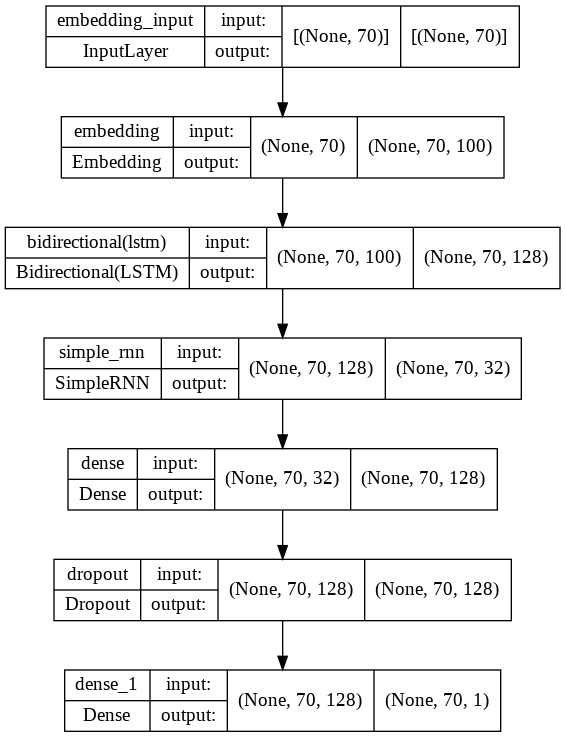

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot_RNN-LSTM.png', show_shapes=True, show_layer_names=True)

### **Train the model**

In [ ]:
history = model.fit(train_sequences, train_labels, batch_size=32, epochs=10, 
                    validation_data=(test_sequences, test_labels), 
                    callbacks=[rlrp] ,verbose=1)

Epoch 1/10
407/407 [==============================] - 43s 96ms/step - loss: 0.3757 - accuracy: 0.8340 - val_loss: 0.1934 - val_accuracy: 0.9237 - lr: 0.0010
Epoch 2/10
407/407 [==============================] - 36s 88ms/step - loss: 0.1387 - accuracy: 0.9546 - val_loss: 0.1671 - val_accuracy: 0.9431 - lr: 0.0010
Epoch 3/10
407/407 [==============================] - 38s 94ms/step - loss: 0.0774 - accuracy: 0.9777 - val_loss: 0.1929 - val_accuracy: 0.9388 - lr: 0.0010
Epoch 4/10
407/407 [==============================] - 38s 93ms/step - loss: 0.0516 - accuracy: 0.9868 - val_loss: 0.2109 - val_accuracy: 0.9388 - lr: 0.0010
Epoch 5/10
407/407 [==============================] - 37s 91ms/step - loss: 0.0359 - accuracy: 0.9925 - val_loss: 0.2271 - val_accuracy: 0.9391 - lr: 1.0000e-04
Epoch 6/10
407/407 [==============================] - 37s 91ms/step - loss: 0.0300 - accuracy: 0.9935 - val_loss: 0.2428 - val_accuracy: 0.9394 - lr: 1.0000e-04
Epoch 7/10
407/407 [==============================

### **Model Evaluated**

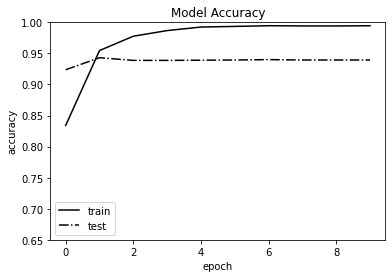

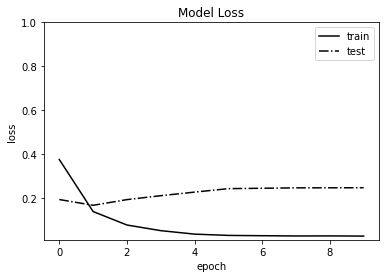

In [ ]:
# score = model.evaluate(test_sequences, test_labels)
# print('Test Loss: ', score[0])
# print('Test Accuracy', score[1])


# list all data in history
#print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['accuracy'], color="black")
plt.plot(history.history['val_accuracy'],color="black", linestyle="-.")
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='bottom right')
plt.ylim((0.650,1.000))
plt.show()

# summarize history for loss
plt.plot(history.history['loss'], color="black")
plt.plot(history.history['val_loss'], color="black", linestyle="-.")
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='bottom left')
plt.ylim((0.010,1.000))
plt.show()

In [ ]:
#hasil AUC
from sklearn.metrics import f1_score, roc_auc_score

predictions = model.predict(test_sequences)
predictions = np.round(predictions).astype(int)
print ("AUC score :", np.round(roc_auc_score(test_labels, predictions),5))

AUC score : 0.94064


In [ ]:
from sklearn.metrics import classification_report,confusion_matrix

pred=model.predict(train_sequences)
arr = np.asarray(train_labels)
pred=np.array([1 if row>=0.5 else 0 for row in pred])
print(classification_report(train_labels, pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      6500
           1       0.99      1.00      0.99      6501

    accuracy                           0.99     13001
   macro avg       0.99      0.99      0.99     13001
weighted avg       0.99      0.99      0.99     13001



In [ ]:
from sklearn.metrics import classification_report,confusion_matrix

pred=model.predict(test_sequences)
arr = np.asarray(test_labels)
pred=np.array([1 if row>=0.5 else 0 for row in pred])
print(classification_report(test_labels, pred))

              precision    recall  f1-score   support

           0       0.95      0.94      0.94      1626
           1       0.94      0.95      0.94      1625

    accuracy                           0.94      3251
   macro avg       0.94      0.94      0.94      3251
weighted avg       0.94      0.94      0.94      3251



In [ ]:
print(confusion_matrix(arr,pred))

[[1521  105]
 [  88 1537]]


In [ ]:
corr= confusion_matrix(arr,pred)
corr = pd.DataFrame(corr, index=["no abusive", "abusive"], columns=["no abusive", "abusive"])
corr.index.name = 'Actual'
corr.columns.name = 'Predicted'

<function matplotlib.pyplot.show>

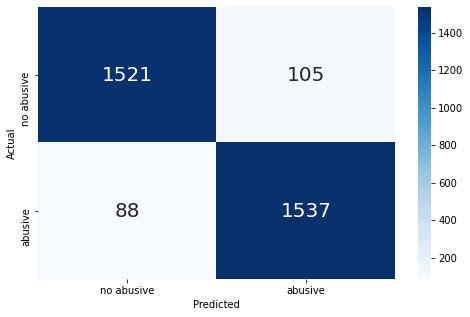

In [ ]:
plt.figure(figsize = (8,5))
sns.heatmap(corr,cmap= "Blues",annot=True, annot_kws={"size": 20}, fmt='')
plt.savefig('confusion matriks', format='png')
plt.show

## **Test Model**

### **Ubah bilangan bulat yang sebelumnya di encode menjadi kata-kata**

In [ ]:
index_to_word = dict([(value, key) for (key, value) in word_index.items()])

def decode_text(text):
    return ' '.join([index_to_word.get(i,'') for i in text])

print(test_sequences[3])
decode_text(test_sequences[3])

[   2 3493 5739    1 1974  498    1  190    1    1    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0]


'user ohh mami 00_V jari pusat 00_V ngentot 00_V 00_V                                                            '

### **Visualisasi embeddings**

In [ ]:
e=model.layers[0]
embeddings = e.get_weights()[0]
print(embeddings.shape) 

(30000, 100)


In [ ]:
indexWord=5000
print('The word',decode_text([indexWord]),'has embedding vector:')
a=embeddings[indexWord]
print('\n',a)
b=embeddings[indexWord+1]
dista = np.linalg.norm(a)
distb = np.linalg.norm(b)
similarity=a.dot(b)/(dista*distb)
print('\nThe similarity between word',decode_text([indexWord]),'and',decode_text([indexWord+1]),'is',similarity)

The word dkung has embedding vector:

 [-0.03449423  0.01629539  0.02018815  0.02071756  0.01813872 -0.02720725
 -0.01031495  0.03322751  0.07343981 -0.02233045  0.00906619  0.01806932
  0.04576821 -0.03357466 -0.04513029  0.04645207 -0.02381242  0.03770612
  0.01634352 -0.053546   -0.01090906 -0.01698034 -0.04344019 -0.01693118
  0.07746737  0.02433    -0.05715385 -0.05963992  0.00186     0.01848468
  0.04074156 -0.04432145 -0.04812784  0.02602061  0.01434146  0.02346219
 -0.01407807  0.0294683  -0.01049631 -0.03560501  0.0317947   0.04704135
  0.0636823   0.01389266 -0.01723363  0.00652157 -0.02632438  0.00975581
  0.06655329  0.05861546  0.0195126   0.05298396 -0.00957494 -0.01307045
  0.04948278 -0.029494   -0.02072156  0.079932    0.00612577  0.03656236
 -0.00531909  0.03901821  0.04817298  0.01769219  0.02182771  0.04820618
 -0.01424821  0.00166172 -0.01378446 -0.01419542 -0.00688935 -0.02967808
 -0.06792149 -0.07208941 -0.02568619  0.00743721 -0.02084108 -0.05390339
  0.064808  

In [ ]:
# Function to draw visualization of distance between embeddings.
def plot_with_labels(low_dim_embs, labels):
    assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
    plt.figure(figsize=(18, 18))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(
          label,
          xy=(x, y),
          xytext=(5, 2),
          textcoords='offset points',
          ha='right',
          va='bottom')

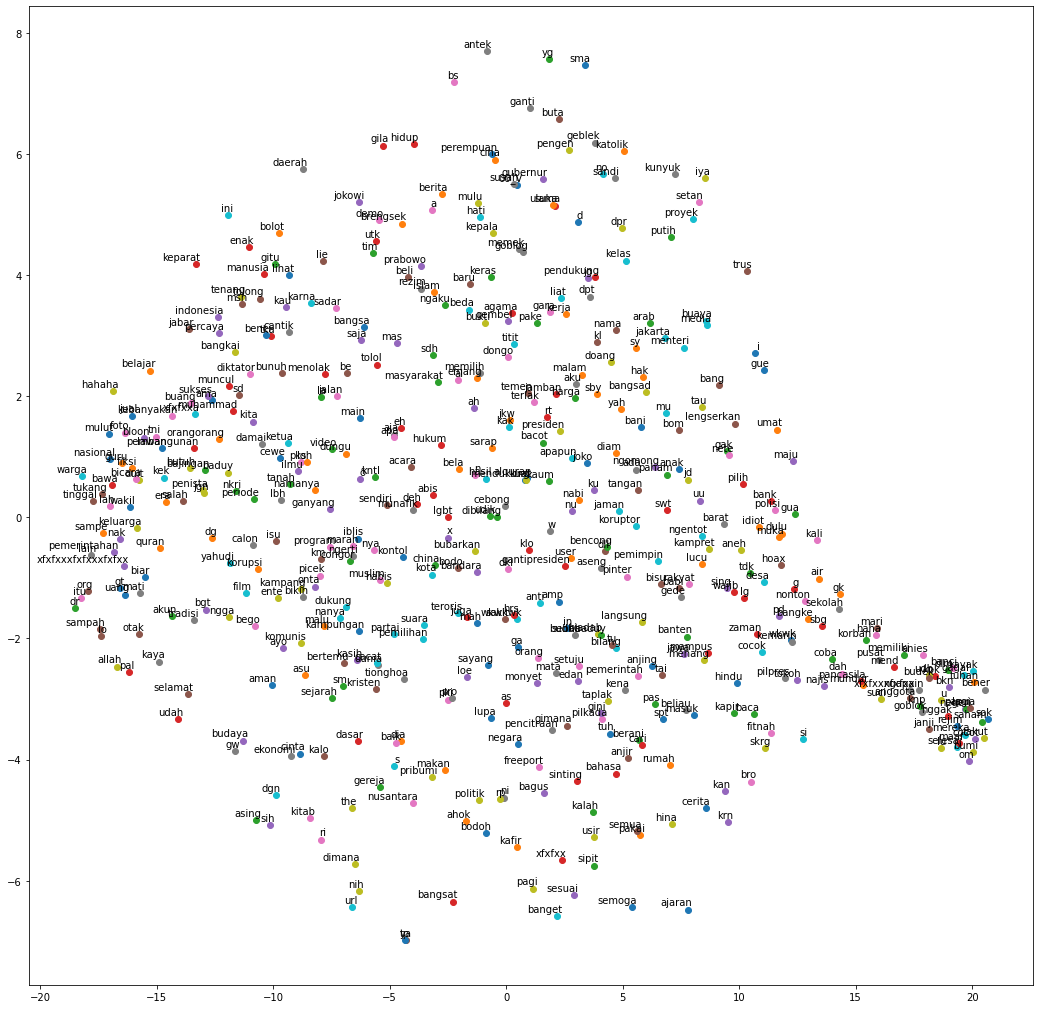

In [ ]:
from sklearn.manifold import TSNE

plot_only = 500
tsne = TSNE(perplexity=50, n_components=2, init='pca', n_iter=7000, method='exact')
low_dim_embs = tsne.fit_transform(embeddings[:plot_only, :])
labels = [index_to_word[i] for i in range(1,plot_only)]
plot_with_labels(low_dim_embs, labels)

### **Test the Model for Sarcasm Detection**

### Test Wrong Answer in System

kemungkinan sistem menjawab atau memberikan jawaban yang salah hanya sekita 3,6 %, angka ini tidak terlalu tinggi, dapat disimpulkan jika sistem mampu memberikan keakuratan jawaban hingga 96,4 %

In [ ]:
#kemungkinan sistem dapat salah prediksi
test_predictions = model.predict_classes(test_sequences)
pred=np.squeeze(test_predictions)
error =  pred != test_labels
wrong_answers=np.sum(error)/len(error)
print('Wrong answers:',wrong_answers*100,'%')

results = model.evaluate(test_sequences, test_labels)
print('The accuracy of the model:',results[1])
print('The loss of the model:',results[0])

Wrong answers: 9.90888382687927 %
83/83 [==============================] - 1s 14ms/step - loss: 0.3934 - accuracy: 0.9009
The accuracy of the model: 0.9009111523628235
The loss of the model: 0.39340290427207947


### Test with Index in Original Dataset

Test dengan memasukkan index di dalam dataset sebagai sampel yang kemudian sistem akan menampilkan output berupa sarkas atau non sarkas

In [ ]:
def test_sentence(index):
  print(decode_text(test_sequences[index]))
  answer=pred[index]
  if 1==answer:
    print('abusive :)')
  else: 
    print('No abusive :(')

In [ ]:
test_sentence(3)

user ohh mami 00_V jari pusat 00_V ngentot 00_V 00_V                                                            
abusive :)


In [ ]:
test_sentence(5)

rt user tau ga responnya 00_V maju sampe muka deket banget beraninya 00_V mata 00_V                                                       
No abusive :(


In [ ]:
test_sentence(11)

rt user retweet nyg 00_V mesum 00_V 00_V indonesia 00_V memek colmek colokmemek jembut 00_V                                                       
abusive :)


In [ ]:
test_sentence(7)

sendirian negara blusukan sumut warta ekonomi                                                                
No abusive :(


In [ ]:
test_sentence(9)

user user user susah bang jawa uda dipegang jokowi antek semua 00_V sih                                                         
No abusive :(


### Test with input some of sentences

memasukkan beberapa kalimat untuk dideteksi tingkat sarcasm dari masing - masing kalimat, sistem akan menampilkan berapa persen tingkat probability kalimat tersebut mengandung kata - kata sarkastik

In [ ]:
#test model yang dibuat untuk mendeteksi kata kata sarcasm melalui kalimat yang dimasukkan
sentence=['najis ih', 'wkwkwk jijik euh', 'dia memang kurang berpendidikan', 'otaknya ngga dipakai']


sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, padding='post',maxlen=100)
p=np.squeeze(model.predict(padded))
for i in range(len(sentence)):
    print('\n',sentence[i],'\n','(probability of abusive --> {:.2%})'.format(p[i]))


 najis ih 
 (probability of abusive --> 93.38%)

 wkwkwk jijik euh 
 (probability of abusive --> 4.92%)

 dia memang kurang berpendidikan 
 (probability of abusive --> 86.71%)

 otaknya ngga dipakai 
 (probability of abusive --> 13.62%)
